## Sequence Modelling with Recurrent Neural Networks - Bitcoin price prediction Bot with RNNs

Here we will
- Process exchange data into sequence chunks
- Build real-valued LSTM networks
- Predict movement of Bitcoin price using LSTMs

In [1]:
%matplotlib notebook

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import sklearn.feature_extraction.text
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
from sklearn import preprocessing
import re
import string

import numpy
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from tqdm import tqdm

plt.ioff()
pd.set_option('display.max_columns', None)

Using TensorFlow backend.


## Download data from [here](https://www.kaggle.com/mczielinski/bitcoin-historical-data/data)

In [2]:
data_frame = pd.read_csv('data/coinbaseUSD_1-min_data_2014-12-01_to_2018-06-27.csv')

In [3]:
data_frame.tail()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
1819069,1530057360,6064.03,6080.00,6064.03,6080.00,10.561973,64148.832294,6073.564990
1819070,1530057420,6080.00,6080.00,6071.52,6077.99,0.682001,4145.298155,6078.136687
1819071,1530057480,6078.00,6081.00,6077.99,6081.00,5.710185,34708.629492,6078.372515
1819072,1530057540,6081.00,6085.70,6074.00,6074.00,20.892658,127050.449960,6081.105271
1819073,1530057600,6074.01,6074.01,6071.52,6071.53,33.898112,205896.111310,6073.969960


In [4]:
prices = data_frame['Weighted_Price']
prices = np.array(prices[-500000:])

<IPython.core.display.Javascript object>


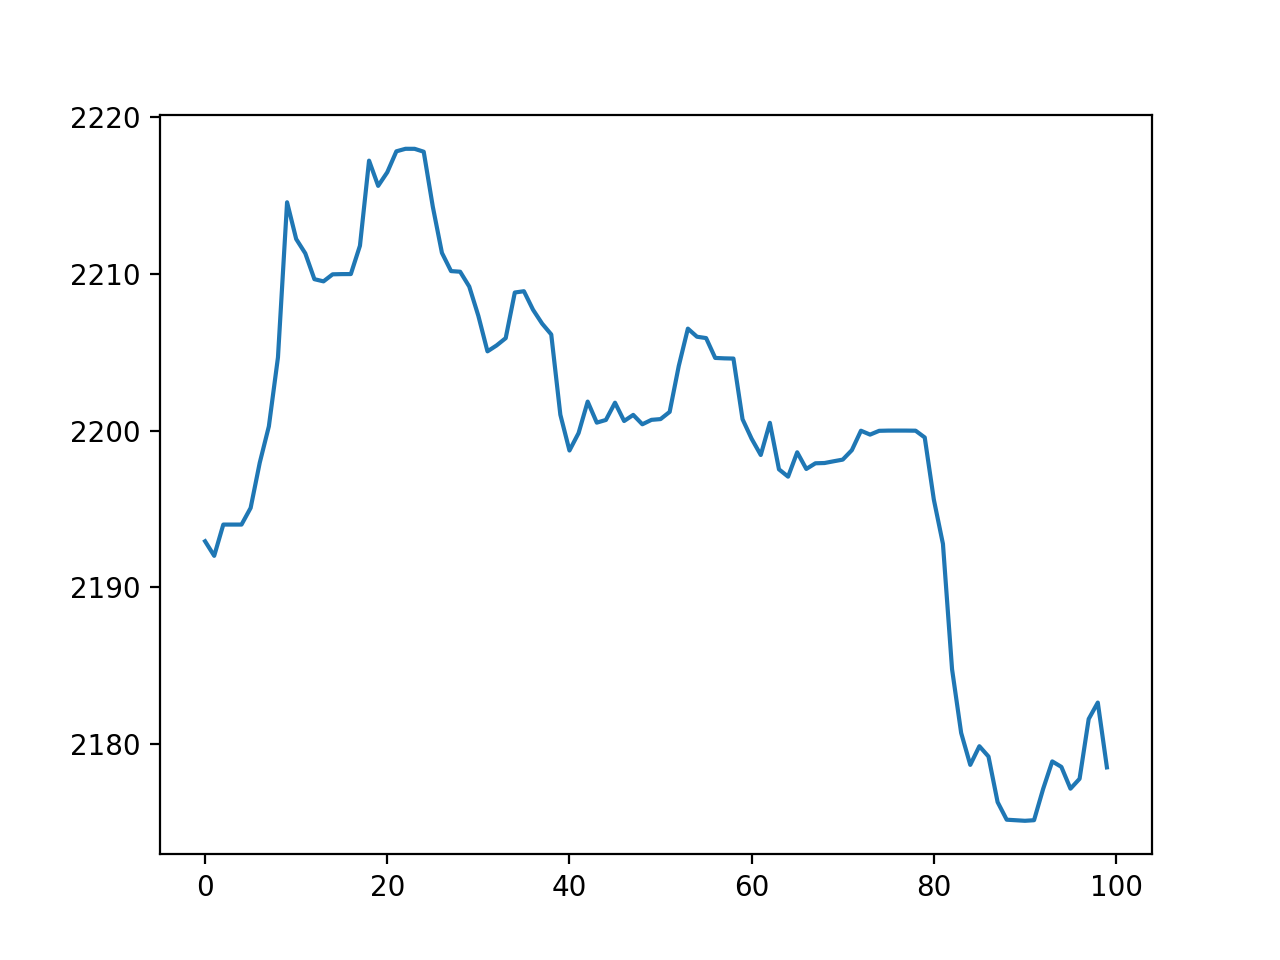

In [5]:
plt.plot(prices[0:100])
plt.show()

In [6]:
X = []
y = []
context_length = 50
gap = 10
for dt in tqdm(range(context_length+1, len(prices)-gap, gap)):
    input_prices = prices[dt-context_length:dt]
    input_percent_change = [[1e5*(prices[dt]-prices[dt-1])/(prices[dt-1])] for dt in range(dt-context_length, dt)]
    price_now = prices[dt+gap]
    percent_change_since_last_knowledge = (input_prices[-1]-price_now)/input_prices[-1]
    is_change_positive = [1, 0] if percent_change_since_last_knowledge > 0 else [0, 1]
    X.append(input_percent_change)
    y.append(is_change_positive)
    
X = np.array(X)
# X = X.reshape((len(X), 1, 100))
y = np.array(y)

100%|██████████| 49994/49994 [00:23<00:00, 2084.61it/s]


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/4., random_state=1)
print(X_train.shape)
print(y_train.shape)

(37495, 50, 1)
(37495, 2)


In [8]:
print(X_train[0:])

[[[  5.39379546e-03]
  [ -4.28926048e-02]
  [ -2.93665924e+01]
  ..., 
  [  2.23529368e+02]
  [ -1.38098889e+01]
  [ -3.18882235e+01]]

 [[ -1.79413964e-04]
  [ -2.40215347e-01]
  [ -1.19210890e-02]
  ..., 
  [ -9.30606706e+01]
  [  4.38160280e+01]
  [ -2.92426319e+00]]

 [[  9.36028044e+01]
  [  2.05193446e+01]
  [  4.88353281e+01]
  ..., 
  [ -4.63544828e+00]
  [ -6.75217262e-01]
  [  5.29531936e+00]]

 ..., 
 [[  9.43662907e+00]
  [  5.57580482e+00]
  [  3.27554850e+01]
  ..., 
  [  9.52011699e+01]
  [  3.02553555e+01]
  [  4.64448828e+00]]

 [[ -7.88375631e-02]
  [ -5.75718346e-02]
  [ -8.25181505e+00]
  ..., 
  [  1.98006089e-02]
  [  3.81862216e-02]
  [  1.56909001e-01]]

 [[  1.01006522e+01]
  [ -2.41149505e+02]
  [ -2.35257234e+02]
  ..., 
  [ -8.28082304e+01]
  [  2.17477208e+01]
  [ -3.36423899e+01]]]


In [ ]:
plt.plot(X[0:50])
plt.show()

In [11]:
# embedding_vector_length = 64
model = Sequential()
# model.add(Embedding(vocab_size, embedding_vector_length, input_length=max_review_length))
model.add(LSTM(128, input_shape=(context_length, 1)))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(X_train, y_train, epochs=5, batch_size=64,  validation_data=(X_test, y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total params: 66,818
Trainable params: 66,818
Non-trainable params: 0
_________________________________________________________________
None
Train on 37495 samples, validate on 12499 samples
Epoch 1/5
37495/37495 [==============================] - 892s 24ms/step - loss: 0.6887 - acc: 0.5455 - val_loss: 0.6866 - val_acc: 0.5458
Epoch 2/5
37495/37495 [==============================] - 2723s 73ms/step - loss: 0.6847 - acc: 0.5520 - val_loss: 0.6812 - val_acc: 0.5575
Epoch 3/5
37495/37495 [==============================] - 800s 21ms/step - loss: 0.6831 - acc: 0.5553 - val_loss: 0.6804 - val_acc: 0.5599
Epoch 4/5
37495/37495 [==============================] - 787s 21

In [12]:
# Final evaluation of the model
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

y_train_pred_class = np.argmax(y_train_pred, axis=1)
y_test_pred_class = np.argmax(y_test_pred, axis=1)
y_train_class = np.argmax(y_train, axis=1)
y_test_class = np.argmax(y_test, axis=1)

train_accuracy = sklearn.metrics.accuracy_score(y_train_class, y_train_pred_class)
test_accuracy = sklearn.metrics.accuracy_score(y_test_class, y_test_pred_class)
print("Train Accuracy {}%".format(train_accuracy*100.0))
print("Test Accuracy {}%".format(test_accuracy*100))

cf_matrix = confusion_matrix(y_test_class, y_test_pred_class)
print("Confusion Matrix")
print(cf_matrix)

Train Accuracy 56.983597813%
Test Accuracy 55.8924713977%
Confusion Matrix
[[3219 2757]
 [2756 3767]]
